In [1]:
import turtle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as spio
import math
import os
from numpy import diff
import pykoopman as pk
from numpy import diff
from sklearn.metrics import mean_squared_error
import sys
# sys.path.append('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils')
# print(sys.path)
# sys.path.remove('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\utils')
from F1tenth_utils import data_preprocess as dp
from F1tenth_utils import plotter_tools
from F1tenth_utils import lift_states
import importlib
importlib.reload(dp)
importlib.reload(plotter_tools)
importlib.reload(lift_states)

import scipy as sc

# Modules from core and koopman core
from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import dubins_car_sys


C:\Users\ajoglek\AppData\Local\Temp\ipykernel_17188\3075481473.py:23: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [3]:
def plot_observables(observables, x, t, input_features=None, t_delay=None):
    '''Generate plots of state variables before and after being transformed into new observables.'''
    n_features = x.shape[1]
    if input_features is None:
        input_features = [f'x{i}' for i in range(n_features)]
    if t_delay is None:
        t_delay = t

    # Plot input features (state variables)
    fig, axs = plt.subplots(1, n_features, figsize=(n_features * 5, 3))

    for ax, k, feat_name in zip(axs, range(n_features), input_features):
        ax.plot(t, x[:, k])
        ax.set(xlabel='t', title=feat_name)
    fig.suptitle('Original state variables')
    fig.tight_layout()
    # fig.show()

    # Plot output features
    y = observables.fit_transform(x)

    n_output_features = observables.n_output_features_
    feature_names = observables.get_feature_names(input_features)

    n_rows = (n_output_features // 3) + (n_output_features % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for ax, k, feat_name in zip(axs.flatten(), range(n_output_features), feature_names):
        ax.plot(t_delay, y[:, k])
        ax.set(xlabel='t', title=feat_name)

    fig.suptitle('Observables')
    fig.tight_layout()
    # fig.show()
    return

In [2]:
# Call the utils function for data pre-processing
X_train, U_train, T_diff = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Train')
X_test, U_test, T_diff_test = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Test')

[Text(0, 0.5, '$\\phi$'), Text(0.5, 0, '$t$')]

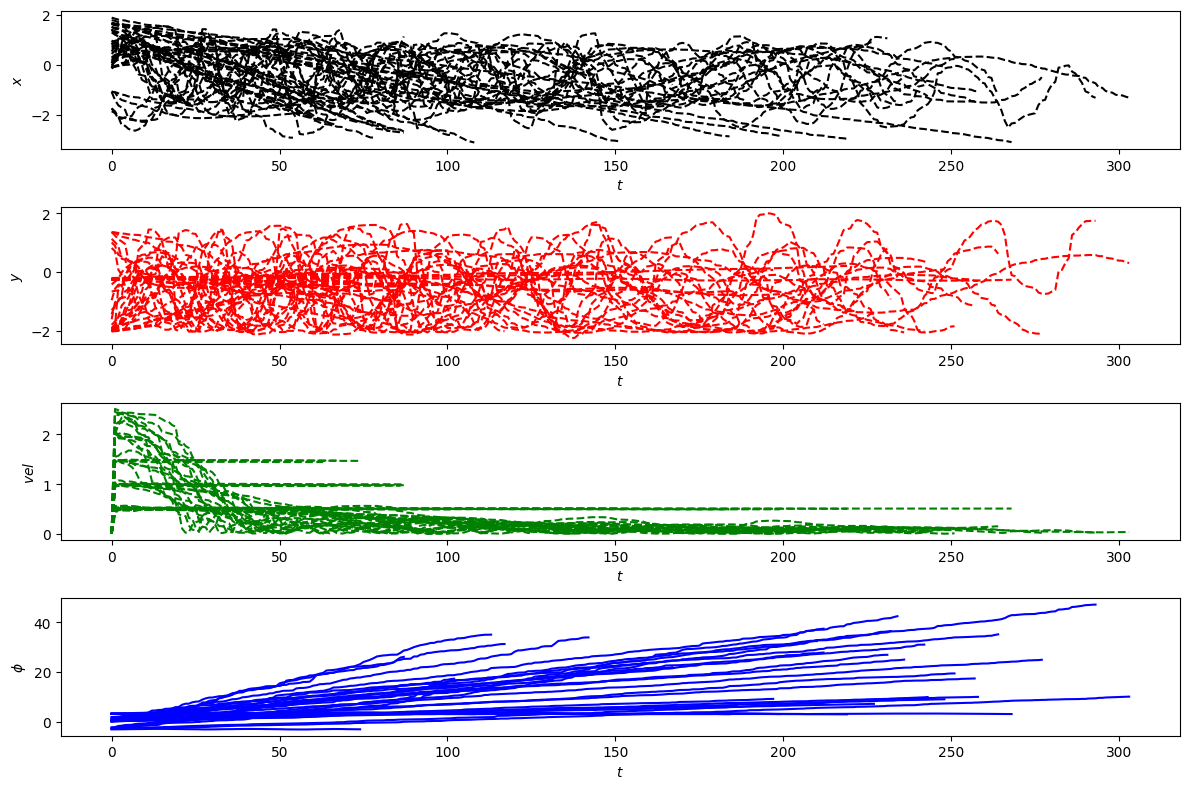

In [5]:
# Plot the data
fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
for i in range(len(X_train) - 3):
    x = X_train[i][:,0]
    y = X_train[i][:,1]
    phi = X_train[i][:,3]
    vel = X_train[i][:,2]
    delta = U_train[i][:,1]
    axs[0].plot(x, '--k')
    axs[1].plot(y, '--r')
    axs[2].plot(vel, '--g')
    axs[3].plot(phi, '-b')
    # axs[4].plot(delta, 'm')
axs[0].set(
        ylabel=r'$x$',
        xlabel=r'$t$')
axs[1].set(
        ylabel=r'$y$',
        xlabel=r'$t$')
axs[2].set(
        ylabel=r'$vel$',
        xlabel=r'$t$')
axs[3].set(
        ylabel=r'$\phi$',
        xlabel=r'$t$')

In [6]:
def lift_states(X):
    # np.seterr(invalid='ignore')
    z_lift = np.zeros([15,X.shape[0]+1])
    for i in range(X.shape[0]):
        data =  X[i,:]
        x1 = data[0]
        x2 = data[1]
        x3 = data[2]
        x4 = data[3]
        t2 = np.cos(x4)
        t3 = np.sin(x4)
        t4 = x3**2
        t5 = x3**3
        t7 = x3**5
        t6 = t4**2
        t8 = np.multiply(t2,x3)
        t9 = np.multiply(t3,x3)
        t10 = np.multiply(t2,t4)
        # t11 = np.multiply(t2,t5)
        # t13 = np.multiply(t2,t7)
        t14 = np.multiply(t3,t4)
        # t15 = np.multiply(t3,t5)
        # t17 = np.multiply(t3,t7)
        # t12 = np.multiply(t2,t6)
        # t16 = np.multiply(t3,t6)
        D = np.array([1.0,x1,x2,x3,x4,t4,t5,t6,t7,t2,t3,t8,t9,t10,t14]).T
        # print(D.shape)
        z_lift[:,i] = D
        # z_lift.reshape(17,-1)
    z_lift[np.isnan(z_lift)] = 0
    return z_lift

In [5]:
def EDMD_koopman(X0,U):
    X0 = np.vstack(X0) # Vertical stack of data runs
    U0 = np.vstack(U)
    # Get temporally shifted data matrix
    X = X0[:-1,:]
    Y = X0[1:,:]

    # Lifting of states
    X_lift = lift_states.lift_states(X)
    Y_lift = lift_states.lift_states(Y)
    zt = X_lift
    zt_plus1 = Y_lift
    zt_control = np.row_stack((X_lift,U0.T)) # Stacking for left shifted control matrix
    print('Array shapes of zt, zt+1 and zt_control are',zt.shape,zt_plus1.shape,zt_control.shape)

    # Koopman A and B matrix by EDMD
    A_B = zt_plus1@zt_control.T@np.linalg.pinv(zt_control@zt_control.T) # Analytical solution for data snapshots
    A_edmd = np.round(A_B[:,:-2],4) # Get A matrix baring the last two columns for control matrix rounded
    B_edmd = np.round(A_B[:,-2:],4) # Get B matrix with the last two columns for control matrix rounded
    print(np.linalg.pinv(zt).shape)
    C_edmd =  np.round(X0.T@np.linalg.pinv(zt))
    return A_B,A_edmd,B_edmd, C_edmd

In [6]:
# Lift the system analytically to get A,B,C matrix from X_train data
from numpy import linalg as LA
AB, A_edmd, B_edmd, Cedmd =  EDMD_koopman(X_train,U_train)
w, v = LA.eig(A_edmd)
print(AB.shape,A_edmd.shape,B_edmd.shape)

Array shapes of zt, zt+1 and zt_control are (15, 8536) (15, 8536) (17, 8536)
(8536, 15)
(15, 17) (15, 15) (15, 2)


Figure name not provided for save file


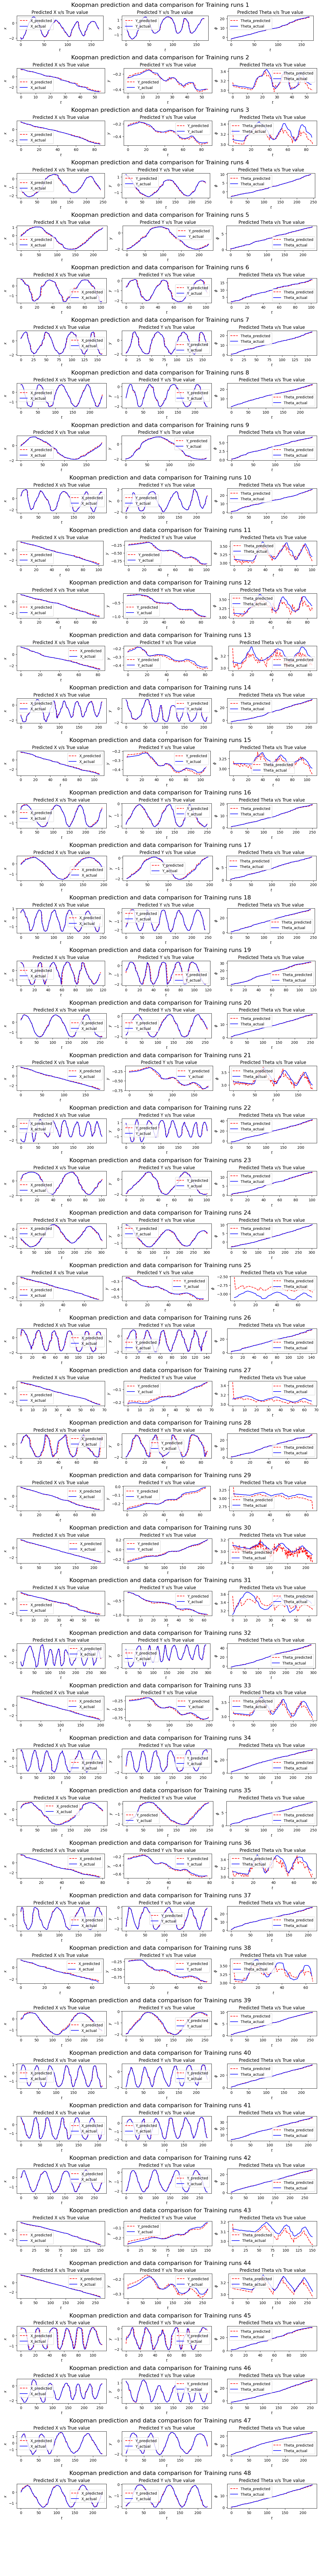

In [12]:
run_name = 'Training runs'
imsave_name = 'Koopman_slalom_noisy_training_prediction'
plotter_tools.plot_lifted_predictions(X_train,A_edmd,B_edmd,U_train,run_name)

Figure name not provided for save file


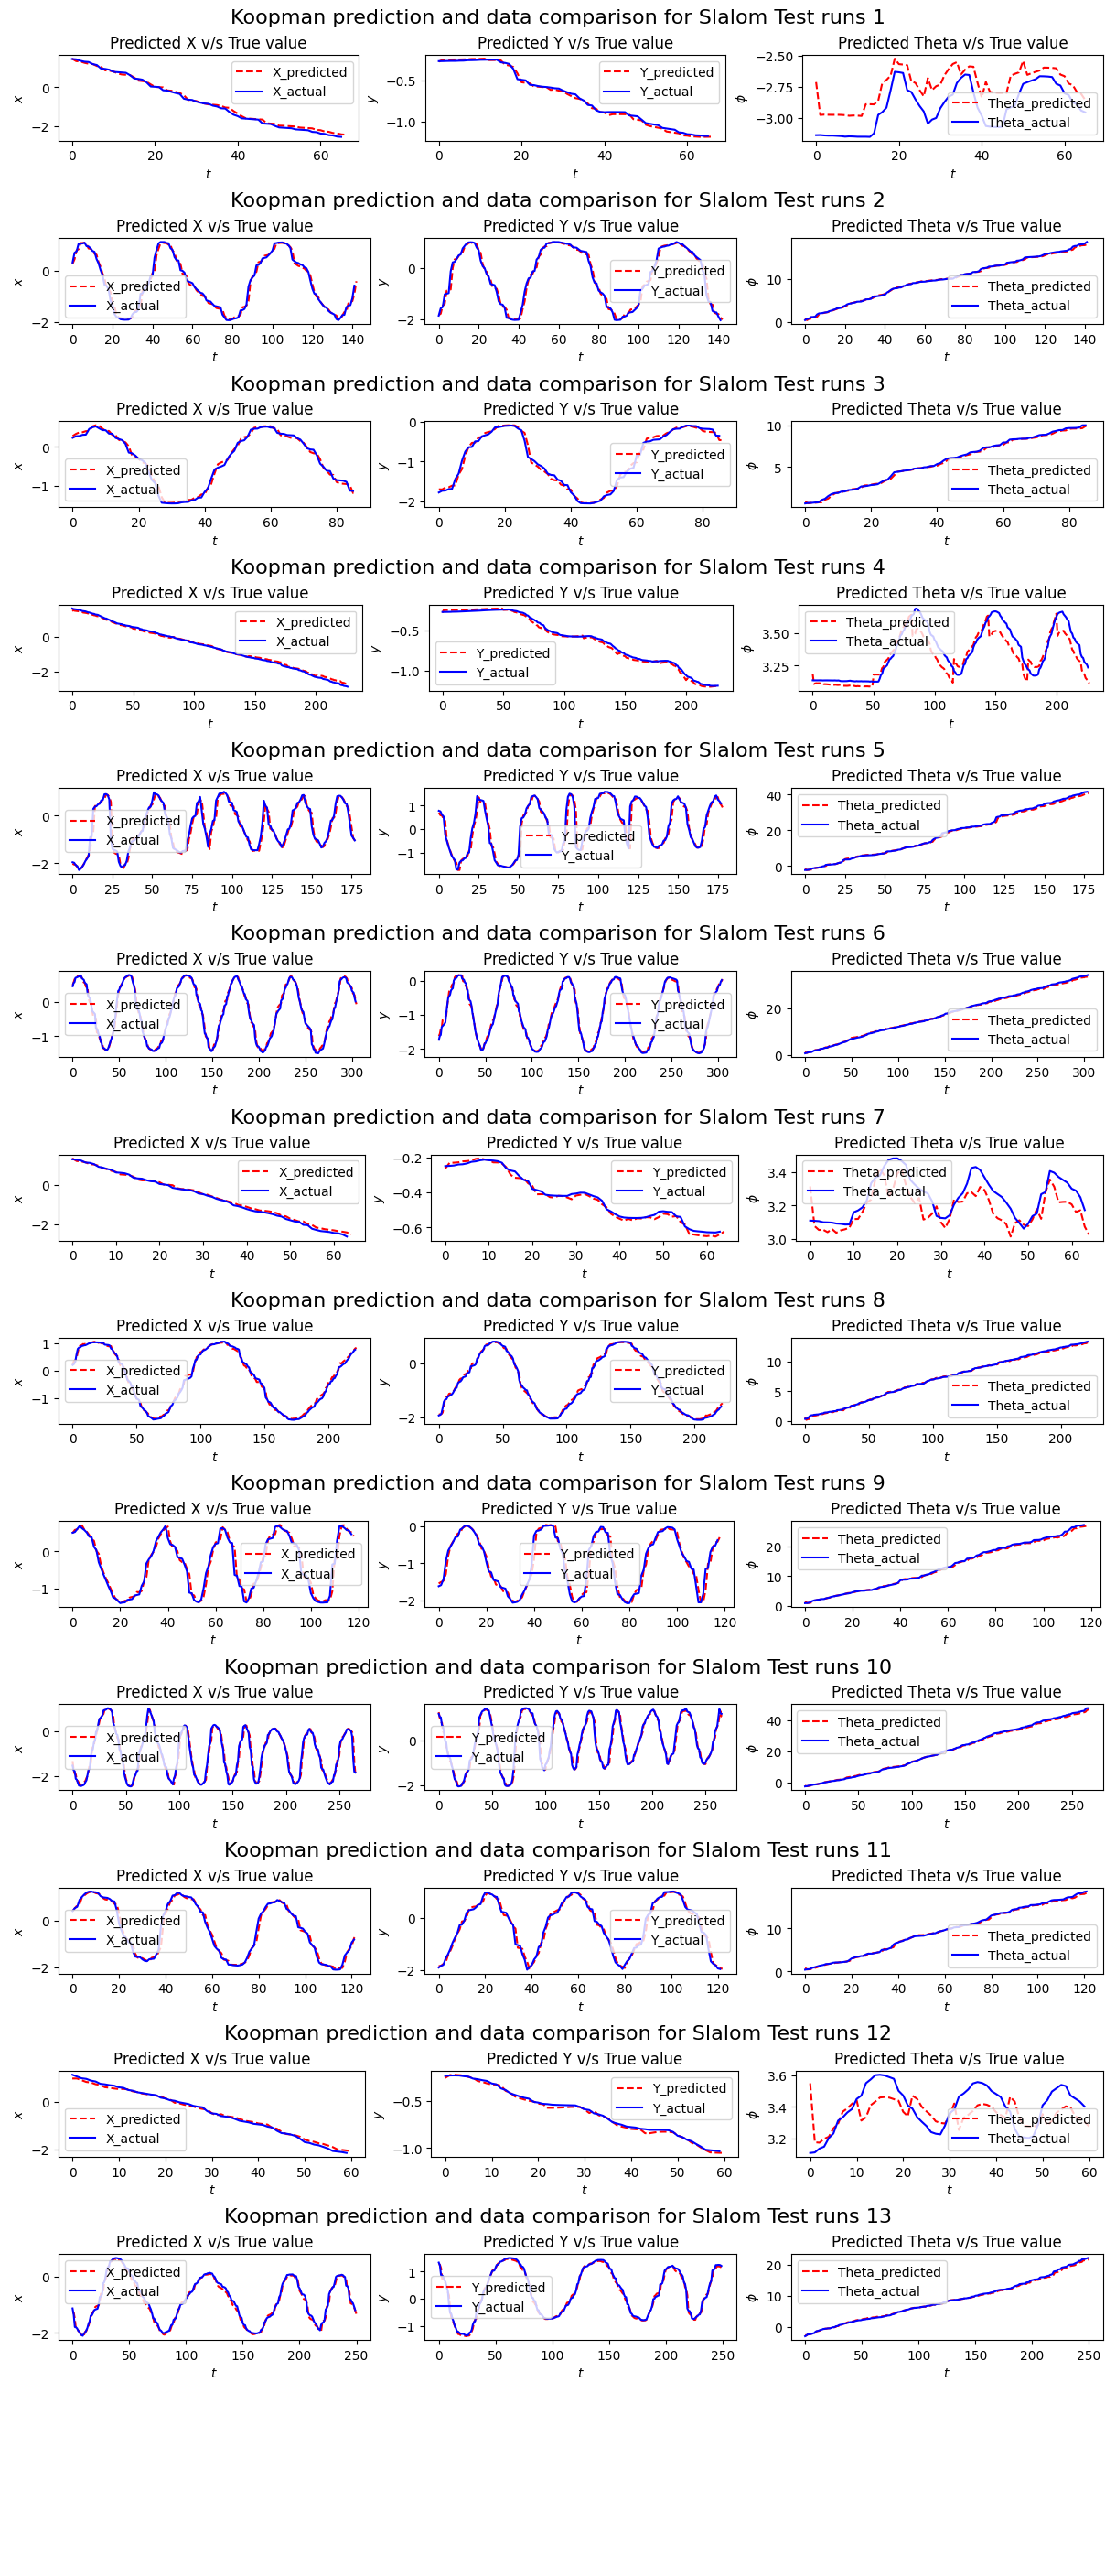

In [38]:
run_name = 'Slalom Test runs'
imsave_name = 'Koopman_testing_prediction'
plotter_tools.plot_lifted_predictions(X_test,A_edmd,B_edmd,U_test,run_name)

In [13]:
# Create a Dubins model for simulating dynamics
mass = 1.5 #Kg
l = 1.2 #m
g = 9.81 # m/S^2
model = dubins_car_sys.Dubin_Car(mass, l, g)


In [11]:
#Set solver settings
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 4000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [15]:
#Setup for MPC parameters
#Closed loop performance evaluation parameters:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0])                       # State penalty matrix, trajectory generation
QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation

NameError: name 'dt' is not defined

In [ ]:
# Creating MPC module around the Koopman EDMD system
# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset.squeeze())

In [15]:
def simulate_ol(A,B,C,X,u):
    zt = lift_states(X)
    u = u.T
    # print(u.shape)
    z_prime = np.zeros((A.shape[0],u.shape[1]))
    z_prime[:,0] = zt[:,1]
    x_hat = []
    x_hat.append(X[0,:])
    # print(x_hat[-1])
    # print(zt.shape,u.shape)
    for i in range(1,u.shape[1]):
            # # x_t = x_hat[:,i-1]
            z_prime[:,i] = A@z_prime[:,i-1] + B@u[:,i-1]
            x_hat_ = C@z_prime[:,i]
            # x_t_1 = x_t +x_hat_*0.1
            x_hat.append(x_hat_)
        # z_t = lift_states(x_hat[-1])
        # z_t_1 = A@z_prime[:,i-1] + B@u[:,i-1]
        # z_prime[:,i] = z_prime[:,i-1] + z_t_1*0.1
        # x_hat_ = C@z_prime[:,i]
        # x_hat.append(x_hat_)


    x_hat = np.vstack(x_hat)

    fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
    # axs[0].plot(y[4,:], '--r')
    axs[0].plot(X[:,0],'b', label='X actual')
    axs[0].plot(x_hat[:,0],'--r')
    axs[1].plot(X[:,1],'b', label='Y actual')
    axs[1].plot(x_hat[:,1],'--r')
    axs[2].plot(X[:,3],'b', label='Theta actual')
    axs[2].plot(x_hat[:,3],'--r')

[5]


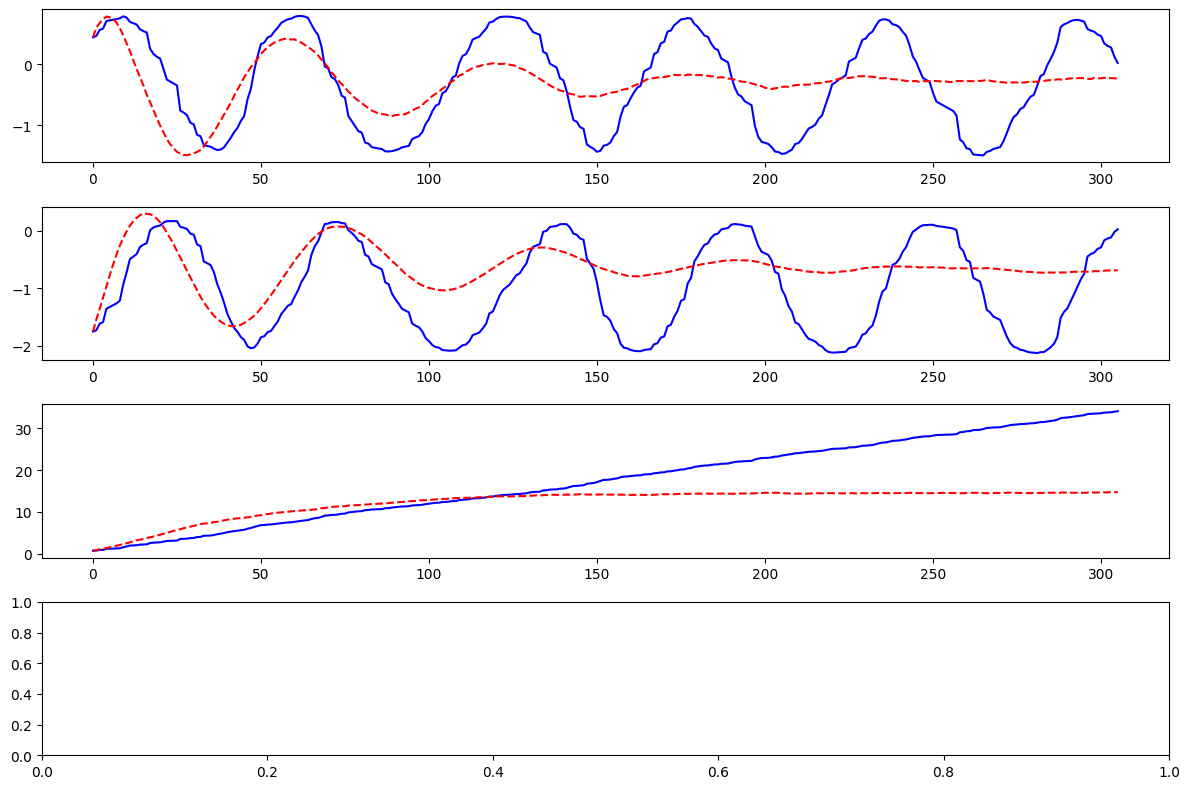

In [18]:
num = np.random.randint(0,len(X_test),1)
print(num)
simulate_ol(A_edmd,B_edmd,Cedmd,X_test[num[0]],U_test[num[0]])

In [29]:
#MPC tryout for  linear model
# Generate data for control problem.
import numpy as np

np.random.seed(1)
n = 8
m = 2
T = 50
alpha = 0.2
beta = 3
A = np.eye(n) - alpha * np.random.rand(n, n)
B = np.random.randn(n, m)
x_0 = beta * np.random.randn(n)

In [103]:
# Form and solve control problem.
import cvxpy as cp
import time
# Pass initial state from robot or sim:
    # Odom data --> Unwrap the angles
    # Send it to control loop
    # Prediction horizon

    # Time step the trajectory based on a counter

x = cp.Variable((n, T + 1))
u = cp.Variable((m, T))

cost = 0
constr = []
t0 = time.time()
for t in range(T):
    # x[:, t + 1] == A @ x[:, t] + B @ u[:, t]
    cost += cp.sum_squares(x[:, t + 1]) + cp.sum_squares(u[:, t])
    constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t], cp.norm(u[:, t], "inf") <= 1]
# sums problem objectives and concatenates constraints.
constr += [x[:, T] == 0, x[:, 0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()
# u.value

# t1 = time.time()
# print(t1-t0)

2515.656065442021

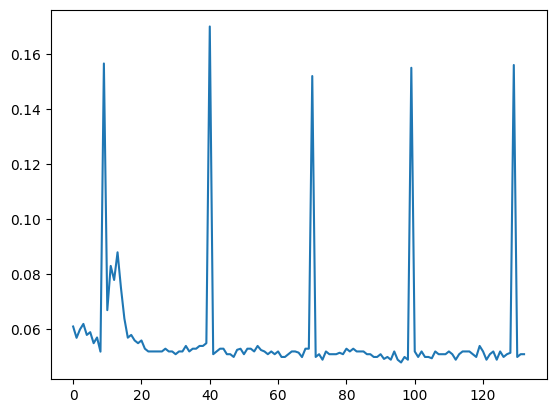

In [23]:
# Linear MPC with cvxpy
import cvxpy as cp
from cvxpy import reshape
from cvxopt import matrix
import time
# Initialization
x_ref = X_test[1]
z_ref = lift_states.lift_states(x_ref)
u_ref = U_test[1].T
N = 10 # Prediction horizon

z_init = np.zeros((z_ref.shape[0],z_ref.shape[1]))
z_init[:,0] = z_ref[:,0]

u_mpc = np.zeros((u_ref.shape[0],u_ref.shape[1]))


Q = np.zeros((15,15))
R = np.eye(2)
Q[1,1] = 1e2 ; Q[2,2] = 1e2; Q[3,3] = 1e2; Q[4,4] = 1e2
umin = np.array([0,-0.5]).reshape(2)
umax = np.array([5,0.5]).reshape(2)
count = 1
time_count = []


while (count < z_ref.shape[1] - N): # Main loop for solver
    # print(count)
    t0 = time.time()
    z_pred = cp.Variable((z_ref.shape[0], N + 1))
    # print(z_pred.shape)
    u_pred = cp.Variable((u_ref.shape[0], N))
    z_ref_ = matrix(z_ref[:,count:count+N+1]) # z_ref_ is the reference window for the current iteration of the loop
    u_ref_ = matrix(u_ref[:,count-1:count+N-1])
    # print(z_ref_.shape,u_ref_.shape)
    cost = 0 # Initializing cost before the loop
    constr = [] # Initializing constaint value
    for i in range(N):
        cost += cp.quad_form(reshape(z_pred[:,i+1],(15,1)) - z_ref_[:,i+1],Q) + cp.quad_form(reshape(u_pred[:,i],(2,1)) - u_ref_[:,i],R) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        constr += [z_pred[:, i + 1] == A_edmd @ z_pred[:, i] + B_edmd @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        # except:
        #     print('Dimension mismatch')
    # sums problem objectives and concatenates constraints.
    constr += [z_pred[:, 0] == z_init[:,count-1]]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(solver=cp.SCS,verbose=False)
    # print(problem.solve())
    u_mpc[:,count] = u_pred.value[:,0]
    z_init[:,count] = A_edmd@z_init[:,count-1] + B_edmd@u_pred.value[:,0]
    count += 1
    t1 = time.time()
    t_diff = t1-t0
    time_count.append(t_diff)


plt.plot(time_count)
# print(z_init.shape)

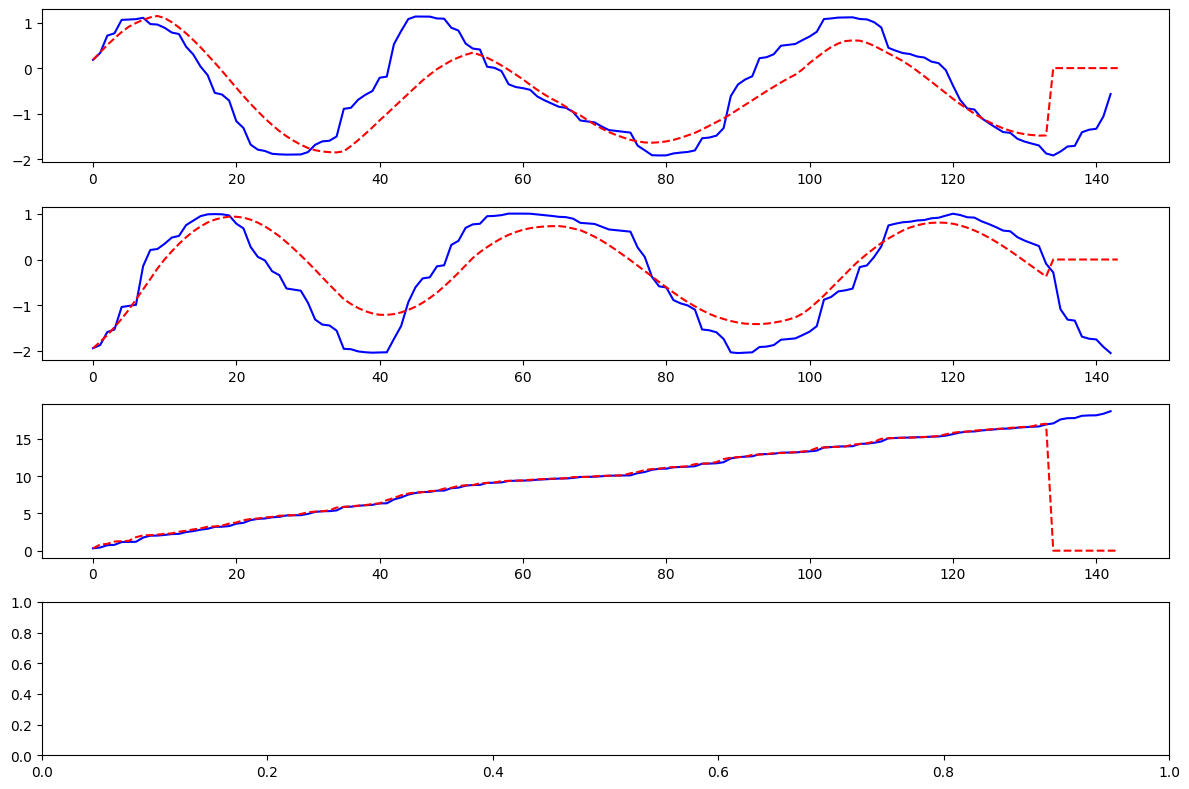

In [24]:
# plt.plot(z_init[:,4])
fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
# axs[0].plot(y[4,:], '--r')
axs[0].plot(X_test[1][:,0],'b', label='X actual')
axs[0].plot(z_init[1,:],'--r')
axs[1].plot(X_test[1][:,1],'b', label='Y actual')
axs[1].plot(z_init[2,:],'--r')
axs[2].plot(X_test[1][:,3],'b', label='Theta actual')
axs[2].plot(z_init[4,:],'--r')

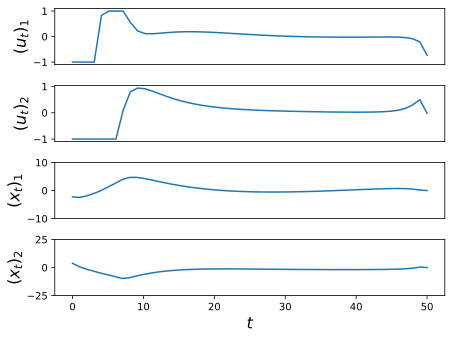

In [44]:
# Plot results.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(u[0, :].value)
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4, 1, 2)
plt.plot(u[1, :].value)
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# Plot (x_t)_1.
plt.subplot(4, 1, 3)
x1 = x[0, :].value
plt.plot(x1)
plt.ylabel(r"$(x_t)_1$", fontsize=16)
plt.yticks([-10, 0, 10])
plt.ylim([-10, 10])
plt.xticks([])

# Plot (x_t)_2.
plt.subplot(4, 1, 4)
x2 = x[1, :].value
plt.plot(range(51), x2)
plt.yticks([-25, 0, 25])
plt.ylim([-25, 25])
plt.ylabel(r"$(x_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()

In [50]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt


# setting matrix_weights' variables
Q_x = 100
Q_y = 100
Q_theta = 2000
R1 = 1
R2 = 1
R3 = 1
R4 = 1

step_horizon = 0.1  # time between steps in seconds
N = 10              # number of look ahead steps
rob_diam = 0.3      # diameter of the robot
wheel_radius = 1    # wheel radius
Lx = 0.3            # L in J Matrix (half robot x-axis length)
Ly = 0.3            # l in J Matrix (half robot y-axis length)
sim_time = 200      # simulation time

# specs
x_init = 0
y_init = 0
theta_init = 0
x_target = 15
y_target = 10
theta_target = pi/4

v_max = 1
v_min = -1


def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())


# state symbolic variables
x = ca.SX.sym('x')
y = ca.SX.sym('y')
theta = ca.SX.sym('theta')
states = ca.vertcat(
    x,
    y,
    theta
)
n_states = states.numel()

# control symbolic variables
V_a = ca.SX.sym('V_a')
V_b = ca.SX.sym('V_b')
V_c = ca.SX.sym('V_c')
V_d = ca.SX.sym('V_d')
controls = ca.vertcat(
    V_a,
    V_b,
    V_c,
    V_d
)
n_controls = controls.numel()

# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)

# matrix containing all control actions over all time steps (each column is an action vector)
U = ca.SX.sym('U', n_controls, N)

# column vector for storing initial state and target state
P = ca.SX.sym('P', n_states + n_states)
print('P is',P)

# state weights matrix (Q_X, Q_Y, Q_THETA)
Q = ca.diagcat(Q_x, Q_y, Q_theta)

# controls weights matrix
R = ca.diagcat(R1, R2, R3, R4)

# discretization model (e.g. x2 = f(x1, v, t) = x1 + v * dt)
rot_3d_z = ca.vertcat(
    ca.horzcat(cos(theta), -sin(theta), 0),
    ca.horzcat(sin(theta),  cos(theta), 0),
    ca.horzcat(         0,           0, 1)
)
# Mecanum wheel transfer function which can be found here:
# https://www.researchgate.net/publication/334319114_Model_Predictive_Control_for_a_Mecanum-wheeled_robot_in_Dynamical_Environments
J = (wheel_radius/4) * ca.DM([
    [         1,         1,          1,         1],
    [        -1,         1,          1,        -1],
    [-1/(Lx+Ly), 1/(Lx+Ly), -1/(Lx+Ly), 1/(Lx+Ly)]
])
# RHS = states + J @ controls * step_horizon  # Euler discretization
RHS = rot_3d_z @ J @ controls
# maps controls from [va, vb, vc, vd].T to [vx, vy, omega].T
f = ca.Function('f', [states, controls], [RHS])


cost_fn = 0  # cost function
g = X[:, 0] - P[:n_states]  # constraints in the equation


# runge kutta
for k in range(N):
    print('IN RK')
    st = X[:, k]
    con = U[:, k]
    cost_fn = cost_fn \
        + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    g = ca.vertcat(g, st_next - st_next_RK4)


OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': cost_fn,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': 2000,
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -ca.inf     # X lower bound
lbx[1: n_states*(N+1): n_states] = -ca.inf     # Y lower bound
lbx[2: n_states*(N+1): n_states] = -ca.inf     # theta lower bound

ubx[0: n_states*(N+1): n_states] = ca.inf      # X upper bound
ubx[1: n_states*(N+1): n_states] = ca.inf      # Y upper bound
ubx[2: n_states*(N+1): n_states] = ca.inf      # theta upper bound

lbx[n_states*(N+1):] = v_min                  # v lower bound for all V
ubx[n_states*(N+1):] = v_max                  # v upper bound for all V


args = {
    'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints lower bound
    'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

t0 = 0
state_init = ca.DM([x_init, y_init, theta_init])        # initial state
state_target = ca.DM([x_target, y_target, theta_target])  # target state

# xx = DM(state_init)
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1)         # initial state full


mpc_iter = 0
cat_states = DM2Arr(X0)
cat_controls = DM2Arr(u0[:, 0])
times = np.array([[0]])


###############################################################################

if __name__ == '__main__':
    main_loop = time()  # return time in sec
    while (ca.norm_2(state_init - state_target) > 1e-1) and (mpc_iter * step_horizon < sim_time):
        t1 = time()
        args['p'] = ca.vertcat(
            state_init,    # current state
            state_target   # target state
        )
        # optimization variable current state
        args['x0'] = ca.vertcat(
            ca.reshape(X0, n_states*(N+1), 1),
            ca.reshape(u0, n_controls*N, 1)
        )

        sol = solver(
            x0=args['x0'],
            lbx=args['lbx'],
            ubx=args['ubx'],
            lbg=args['lbg'],
            ubg=args['ubg'],
            p=args['p']
        )

        u = ca.reshape(sol['x'][n_states * (N + 1):], n_controls, N)
        X0 = ca.reshape(sol['x'][: n_states * (N+1)], n_states, N+1)

        cat_states = np.dstack((
            cat_states,
            DM2Arr(X0)
        ))

        cat_controls = np.vstack((
            cat_controls,
            DM2Arr(u[:, 0])
        ))
        t = np.vstack((
            t,
            t0
        ))

        t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

        # print(X0)
        X0 = ca.horzcat(
            X0[:, 1:],
            ca.reshape(X0[:, -1], -1, 1)
        )

        # xx ...
        t2 = time()
        print(mpc_iter)
        print(t2-t1)
        times = np.vstack((
            times,
            t2-t1
        ))

        mpc_iter = mpc_iter + 1

    main_loop_time = time()
    ss_error = ca.norm_2(state_init - state_target)

    print('\n\n')
    print('Total time: ', main_loop_time - main_loop)
    print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
    print('final error: ', ss_error)

P is [P_0, P_1, P_2, P_3, P_4, P_5]
IN RK
IN RK
IN RK
IN RK
IN RK
IN RK
IN RK
IN RK
IN RK
IN RK


KeyboardInterrupt: 